# Early ICU Admission Notebook

---
embed-resources: true
---

## Introduction

This project explores how changes in patient vital signs can be used to predict early signs of clinical deterioration and the need for ICU transfer. By combining nursing expertise with data analysis, it demonstrates how data-driven insights can improve patient outcomes and support proactive decision-making in healthcare. Using simulated patient data, the analysis focuses on variables such as heart rate, respiratory rate, blood pressure, and oxygen saturation to identify key predictors of decline. Visualizations and correlation analysis will help highlight which vital signs most strongly indicate risk. The goal is to create a concise, evidence-based summary that connects data patterns to real clinical practice and early intervention.

## Methods

In [203]:
# ==========================
# Core Libraries
# ==========================
import pandas as pd
import numpy as np

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Machine Learning Tools
# ==========================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# ==========================
# Evaluation Metrics
# ==========================
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Data

In [204]:
# load data
df = pd.read_csv("/Users/trustanprice/Desktop/Personal/icu-predictions/data/icu-data.csv")

In [205]:
# Combine ICU indicators into one binary variable
df["ICU_Admission"] = df[["CCU", "CSRU", "SICU"]].max(axis=1)
df = df.drop(columns=["CCU", "CSRU", "SICU"])
df["ICU_Admission"].value_counts()

ICU_Admission
1    2290
0    1310
Name: count, dtype: int64

In [206]:
print(df.head())
print(df.shape)

   recordid  SAPS-I  SOFA   Age  Gender  Height  Weight  DiasABP_first  \
0    137517      -1     2  56.0     0.0     NaN    79.6            NaN   
1    145680      10     3  72.0     1.0     NaN    70.0            NaN   
2    138649      -1     8  81.0     0.0     NaN     NaN            NaN   
3    149075      16     8  56.0     1.0   180.3    94.8           55.0   
4    141408      14     7  52.0     1.0   182.9   120.6           80.0   

   GCS_first  Glucose_first  ...  TroponinI_last  TroponinT_last  WBC_last  \
0       15.0          237.0  ...             NaN             NaN       7.3   
1       15.0          114.0  ...             NaN            0.07       2.4   
2        6.0           73.0  ...             NaN             NaN       7.0   
3       15.0          146.0  ...             NaN             NaN      11.4   
4       10.0          120.0  ...             NaN             NaN       9.0   

   Weight_last  pH_last  MechVentStartTime  MechVentDuration  \
0         79.6      Na

### About the Dataset

#### Response  

`In-hospital_death`  
- **[int]** Binary indicator of patient outcome during hospitalization (0 = survived, 1 = died).  

---

#### Features  

`recordid`  
- **[int]** Unique identifier for each patient record.  

`Age`  
- **[float]** Patient’s age in years.  

`Gender`  
- **[int]** Encoded as 0/1 indicating patient gender (e.g., 0 = female, 1 = male).  

`Height`, `Weight`  
- **[float]** Patient’s physical measurements in centimeters and kilograms.  

`CCU`, `CSRU`, `SICU`  
- **[int]** Binary indicators for the ICU type: Coronary Care Unit, Cardiac Surgery Recovery Unit, or Surgical Intensive Care Unit.  

`SAPS-I`  
- **[float]** Simplified Acute Physiology Score representing overall severity of illness.  

`SOFA`  
- **[float]** Sequential Organ Failure Assessment score tracking organ dysfunction over time.  

`[Parameter]_first`, `[Parameter]_last`, `[Parameter]_lowest`, `[Parameter]_highest`, `[Parameter]_median`  
- **[float]** Clinical measurements recorded at different time points for vital signs such as:  
  - `HR` (Heart Rate)  
  - `RespRate` (Respiratory Rate)  
  - `SysABP`, `DiasABP`, `MAP` (Blood Pressure measures)  
  - `SaO2` (Oxygen Saturation)  
  - `Temp` (Body Temperature)  
  - `GCS` (Glasgow Coma Scale)  
  - `Glucose` (Blood Glucose Level)  

---

#### Laboratory Test Results  

`Albumin`, `ALP`, `ALT`, `AST`, `BUN`, `Bilirubin`, `Cholesterol`, `Creatinine`, `FiO2`, `HCO3`, `HCT`, `K`, `Lactate`, `Mg`, `Na`, `PaCO2`, `PaO2`, `Platelets`, `TroponinI`, `TroponinT`, `WBC`, `pH`  
- **[float]** Lab values recorded at various points during the ICU stay, representing organ function, oxygenation, and metabolic balance.  

---

#### Ventilator and Urine Output Data  

`MechVentStartTime`  
- **[datetime]** Timestamp indicating the start of mechanical ventilation.  

`MechVentDuration`  
- **[float]** Duration of mechanical ventilation (in hours or minutes).  

`MechVentLast8Hour`  
- **[int]** Indicator for whether ventilation occurred in the last 8 hours of the ICU stay.  

`UrineOutputSum`  
- **[float]** Total urine output (in mL) during the patient’s ICU stay.  


### Summary Statistics

In [207]:
# Count and percent of missing values per feature
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_percent = (df.isna().mean() * 100).sort_values(ascending=False)

# Combine into one DataFrame
na_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent
})

# Display top 15 columns with most missing values
print(na_summary.head(15))

                   Missing Count  Missing %
TroponinI_first             3425  95.138889
TroponinI_last              3425  95.138889
Cholesterol_first           3325  92.361111
Cholesterol_last            3325  92.361111
TroponinT_last              2814  78.166667
TroponinT_first             2814  78.166667
RespRate_highest            2606  72.388889
RespRate_last               2606  72.388889
RespRate_median             2606  72.388889
RespRate_lowest             2606  72.388889
RespRate_first              2606  72.388889
Albumin_first               2128  59.111111
Albumin_last                2128  59.111111
ALP_first                   2068  57.444444
ALP_last                    2068  57.444444


In [208]:
# 1) Compute missingness on the original DataFrame
threshold = 0.35  # 35%
missing_frac = df.isna().mean()  # fraction of NAs per column

# 2) Identify columns to drop (>= 35% missing)
to_drop = missing_frac[missing_frac >= threshold].index.tolist()

print(f"Columns to drop (>= {threshold*100:.0f}% missing): {len(to_drop)}")
print(to_drop[:25])  # preview first 25

# 3) Drop them
df = df.drop(columns=to_drop)

# 4) Verify result
print("\nNew shape after drop:", df.shape)

# Optional: sanity check top remaining NA columns
print("\nTop remaining NA columns:")
print(df.isna().mean().sort_values(ascending=False).head(10))

Columns to drop (>= 35% missing): 33
['Height', 'RespRate_first', 'SaO2_first', 'RespRate_last', 'SaO2_last', 'RespRate_lowest', 'SaO2_lowest', 'RespRate_highest', 'SaO2_highest', 'RespRate_median', 'SaO2_median', 'ALP_first', 'ALT_first', 'AST_first', 'Albumin_first', 'Bilirubin_first', 'Cholesterol_first', 'Lactate_first', 'TroponinI_first', 'TroponinT_first', 'ALP_last', 'ALT_last', 'AST_last', 'Albumin_last', 'Bilirubin_last']

New shape after drop: (3600, 85)

Top remaining NA columns:
Weight_last        0.331389
Weight_first       0.331389
FiO2_last          0.325278
FiO2_first         0.325278
SysABP_median      0.307778
DiasABP_median     0.307778
SysABP_lowest      0.307778
DiasABP_highest    0.307778
DiasABP_last       0.307778
SysABP_highest     0.307778
dtype: float64


In [209]:
num_summary = df.describe().T
num_summary['skew'] = df.skew()
num_summary['kurtosis'] = df.kurtosis()

print(num_summary.head(10))

                count           mean          std       min       25%  \
recordid       3600.0  140964.911389  5583.521700  132539.0  136374.5   
SAPS-I         3600.0      14.187500     6.061105      -1.0      11.0   
SOFA           3600.0       6.311111     4.191431      -1.0       3.0   
Age            3600.0      64.462778    17.630796      15.0      53.0   
Gender         3596.0       0.563126     0.496068       0.0       0.0   
Weight         3277.0      81.729774    23.677343      36.5      66.0   
DiasABP_first  2492.0      62.552568    14.306954       4.0      53.0   
GCS_first      3535.0      10.090240     4.893033       3.0       5.5   
Glucose_first  3500.0     148.228857    76.227626       8.0     108.0   
HR_first       3535.0      89.686280    20.344884      33.0      76.0   

                    50%        75%       max      skew   kurtosis  
recordid       140071.5  145233.75  152851.0  0.444101  -0.861693  
SAPS-I             15.0      18.00      34.0 -0.455939   0.3

In [210]:
# exploratory visualization

### Models

In [211]:
# Define target and features
target_col = "ICU_Admission"
X = df.drop(columns=[target_col])
y = df[target_col]

# Impute missing values
X = X.fillna(X.median())

# Standardize numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [212]:
model = LogisticRegression(max_iter=1000, penalty='l2', solver='lbfgs')
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## Results

In [213]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy on Test Set: {accuracy:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy on Test Set: 0.731

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.58      0.61       262
           1       0.77      0.82      0.79       458

    accuracy                           0.73       720
   macro avg       0.71      0.70      0.70       720
weighted avg       0.73      0.73      0.73       720



In [214]:
# report model metrics
importance = pd.Series(model.coef_[0], index=X.columns)

# Sort by absolute value
importance = importance.reindex(importance.abs().sort_values(ascending=False).index)

# Display top 15 features
print("Top 15 Most Influential Features:\n")
print(importance.head(15))

Top 15 Most Influential Features:

BUN_first          -0.643902
GCS_first          -0.462348
Platelets_last     -0.429572
Temp_median         0.393378
HCT_first           0.379155
GCS_median          0.366851
NIMAP_last          0.365632
Platelets_first     0.340862
NIMAP_median        0.334059
PaO2_first          0.332491
Weight_last         0.323631
NIDiasABP_median   -0.302112
NIDiasABP_last     -0.284608
SysABP_first        0.278244
HCO3_last           0.276541
dtype: float64


In [215]:
odds_ratios = np.exp(model.coef_[0])
odds_df = pd.DataFrame({
    "Feature": X.columns,
    "Odds Ratio": odds_ratios
}).sort_values(by="Odds Ratio", ascending=False)

print(odds_df.head(10))

            Feature  Odds Ratio
55      Temp_median    1.481979
60        HCT_first    1.461050
47       GCS_median    1.443184
22       NIMAP_last    1.441424
66  Platelets_first    1.406159
52     NIMAP_median    1.396625
65       PaO2_first    1.394437
82      Weight_last    1.382137
14     SysABP_first    1.320808
73        HCO3_last    1.318561


### Summary Figure

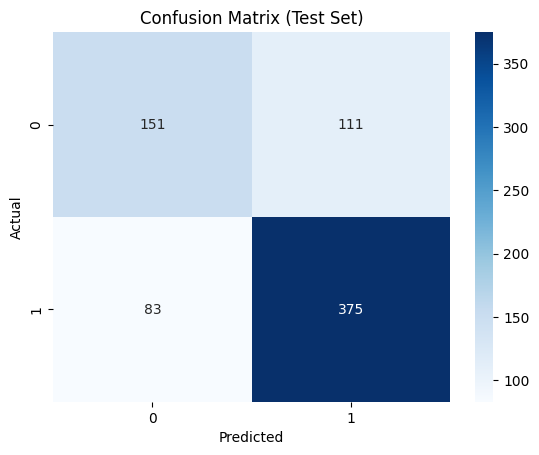

In [216]:

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [217]:
# serialize model

## Discussion